# Create GeoTIFF Grids from Subsets Response
This tutorial shows how to create GeoTiff grids from the ORNL DAAC's [Subsets API](https://modis.ornl.gov/data/modis_webservice.html) response.

This tutorial requires the following Python modules installed in your system: `requests`, `numpy`, `rasterio`, `h5py` and `matplotlib`. Requirements are also in requirements.txt. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
pip install -r requirements.txt
```
Let's first import the required python modules.

In [1]:
import requests
import numpy as np
import rasterio
import glob
import tarfile
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os import path
from rasterio.plot import show

In this tutorial, we will retrieve a subset for VIIRS vegetation index product ([VNP13A1](https://doi.org/10.5067/VIIRS/VNP13A1.001)) for an area near [Lopé National Park](https://en.wikipedia.org/wiki/Lop%C3%A9_National_Park) (Latitude: `0.26918S`, Longitude: `11.6573E`) in Gabon. We will request a subset area of about 20km x 20km for one time period (January 01, 2013).

Now, let's build the parameters.

In [2]:
# base URL
baseurl ="https://modis.ornl.gov/rst/api/v1/"
# product
product = "VNP13A1"

# parameters
params = {
    "latitude": -0.26918, 
    "longitude": 11.6573,
    "startDate": 'A2013001',
    "endDate": 'A2013001',
    "kmAboveBelow": 10,
    "kmLeftRight": 10,
    "band": "500_m_16_days_EVI"
}

Now, let's submit a GET request to the API with the above parameters.

In [3]:
# API endpoint
modis_api = f'{baseurl}/{product}/subset'

# submit the request
r = requests.get(modis_api, params=params)
# check if the request is successful
r.raise_for_status()
# print subset
subset = r.json()
subset

{'xllcorner': '1286619.37',
 'yllcorner': '-39381.62',
 'cellsize': 463.312716528,
 'nrows': 41,
 'ncols': 41,
 'band': '500_m_16_days_EVI',
 'units': 'EVI ratio - No units',
 'scale': '0.0001',
 'latitude': -0.26918,
 'longitude': 11.6573,
 'header': 'https://modisrest.ornl.gov/rst/api/v1/VNP13A1/subset?latitude=-0.26918&longitude=11.6573&startDate=A2013001&endDate=A2013001&kmAboveBelow=10&kmLeftRight=10&band=500_m_16_days_EVI',
 'subset': [{'modis_date': 'A2013001',
   'calendar_date': '2013-01-01',
   'band': '500_m_16_days_EVI',
   'tile': 'h19v09',
   'proc_date': '2018141173132',
   'data': [4792,
    4163,
    5355,
    5364,
    4823,
    4156,
    4183,
    4037,
    4297,
    5000,
    4909,
    4179,
    4279,
    4289,
    4265,
    4496,
    5000,
    5002,
    4510,
    4699,
    4746,
    4683,
    4573,
    4981,
    4930,
    4924,
    4622,
    3793,
    4733,
    5133,
    4800,
    5018,
    4733,
    5249,
    5016,
    4865,
    2856,
    3274,
    4051,
    4035,

Now, let's retrieve all the subset data.

In [4]:
xllcorner = float(subset['xllcorner'])
yllcorner = float(subset['yllcorner'])
cellsize = float(subset['cellsize'])
nrows = int(subset['nrows'])
ncols = int(subset['ncols'])
scale = float(subset['scale'])
data = np.array(subset['subset'][0]['data'], dtype = 'int32')

# print shape of data array
data.shape

(1681,)

The subset numpy array above needs to be put into correct orientation and reshaped. 

In [5]:
# create a grid with correct orientation
data = np.flipud(data.reshape(nrows, ncols))
# print shape of data array
data.shape

(41, 41)

Let's also define the projection of MODIS tiles in Well-Known Text (WKT) format and the transformation parameter.

In [6]:
# sinusoidal projection
crs = '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext'

# affine transformation
transform = rasterio.transform.from_origin(xllcorner, yllcorner, cellsize, -cellsize)

We can now use the above transformation to create a geotiff file from the numpy array.

In [7]:
# writing to geotiff
with rasterio.open('vnp13a1_evi.tif', 'w', 
                   driver='GTiff', 
                   height=nrows, width=ncols, 
                   count=1,
                   dtype=data.dtype,
                   crs=crs, transform=transform) as grid:
    grid.write(data, 1)

We just created a geotiff file called `vnp13a1_evi.tif`. Let's visualize the geotiff file.

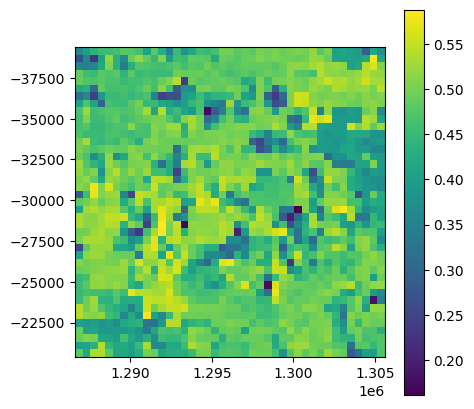

In [8]:
with rasterio.open('vnp13a1_evi.tif') as src:
    grid2 = src.read(1, masked=True)
    fig, ax = plt.subplots(figsize=(5,5))
    # color bar
    fig.colorbar(ax.imshow(grid2*scale), ax=ax)
    rasterio.plot.show(grid2, transform=src.transform, ax=ax)

The above geotiff file can now be imported to a GIS system for further analysis. If you want to apply quality filter to this dataset, please refer to [this tutorial](https://github.com/ornldaac/modis_restservice_qc_filter_Python/blob/master/modis_restservice_qc_filter_Python.ipynb) for further details.

# Retrieve ICESAT ATL08 subset data
Now, let's submit [Global Subset requests](https://modis.ornl.gov/globalsubset/) for ICESAT-2/ATLAS L3A Land and Vegetation Height ([ATL08](https://doi.org/10.5067/ATLAS/ATL08.005)) for the same subset location. It will take some time to finish processing the subset orders, and once the subsets are ready you will receive emails with the links to the order delivery pages like following: https://modis.ornl.gov/subsetdata/10Apr2023_13:44:55_925303977L-0.26918L11.65730S21L21_ATL08_1

Let's download the HDF5 files from the the order delivery pages and save it to the folder here. `HDF5.tar.gz` files contains the compressed version of these files.

In [9]:
# function to download and untar file file
def download_tar(url):
    r = requests.get(url, stream=True)
    r.raise_for_status()
    h5_tar = path.basename(url)
    with open(h5_tar, 'wb') as f:
        f.write(r.raw.read())
    with tarfile.open(h5_tar) as f:
        f.extractall() 

# order URL
order_url = 'https://modis.ornl.gov/subsetdata'
orderid = '10Apr2023_13:44:55_925303977L-0.26918L11.65730S21L21_ATL08_1'
h5_tar = 'HDF5.tar.gz'

# download and uncompress ATL08 files
download_tar(f'{order_url}/{orderid}/h5/{h5_tar}')

Now, let's print all the ATL08 files we just downloaded.

In [10]:
atl08_f = glob.glob("ATL08*")
atl08_f

['ATL08_20220607111220_11661508_005_02.h5',
 'ATL08_20210609043242_11661108_005_01.h5',
 'ATL08_20220906065216_11661608_005_01.h5',
 'ATL08_20220521235123_09141514_005_03.h5']

We can now plot the photons height (`ph_h`) and classification (`classed_pc_flag`) of a ATL08 file.

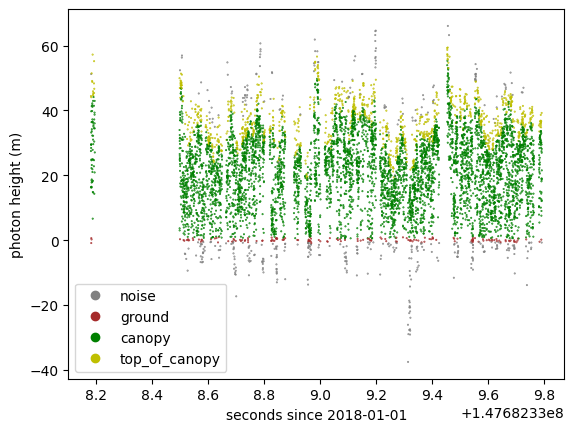

In [11]:
# reading one atl08 file
for h5_f in atl08_f[2:3]:
    with h5py.File(h5_f) as hf:
        for var in list(hf.keys()):
            if var.startswith('gt'):
                ph_h= hf[var]['signal_photons']['ph_h'][:]
                classed_pc_flag = hf[var]['signal_photons']['classed_pc_flag'][:]
                delta_time = hf[var]['signal_photons']['delta_time'][:] 

# photon classes
classes = ['noise', 'ground', 'canopy', 'top_of_canopy']   
colors = ListedColormap(['gray','brown','green','y'])
scatter = plt.scatter(delta_time,ph_h,c=classed_pc_flag, cmap=colors, s=0.2)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.xlabel("seconds since 2018-01-01")
plt.ylabel("photon height (m)")
plt.show()

The subset data is also provided in a `GeoJSON` format which can be used to directly import the ICESAT-2 ATL08 data into a GIS software.